In [1]:
import os.path
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from dataset import SimpleRegression
from models import SigmoidNet, ReLUNet, AbsNet, SigmoidNormNet, ReLUNormNet, weights_init_normal
from torch.utils.data import DataLoader
from main import bump_func
import torch.nn as nn

def plot_3d(array, txt=None):
    x = np.arange(0, array.shape[0])
    y = np.arange(0, array.shape[1])
    xv, vy = np.meshgrid(x, y)
    
    xv = np.reshape(xv, [-1])
    vy = np.reshape(vy, [-1])
    data = np.reshape(array, [-1])

    fig = plt.figure(figsize=(9, 9))
    ax = plt.axes(projection="3d")
    ax.scatter3D(xv, vy, np.abs(data), alpha=0.6, label="abs_weights")
    ax.set_xlabel("Number of Iteration")
    ax.set_ylabel("Neuron Index")
    ax.set_zlabel("Grad (abs) Value")
    ax.grid()
    ax.legend()
    if txt is not None:
        ax.set_title(txt)
    plt.show()

In [2]:
# === Config for reproduction
seed = 0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Exp setups
total_epoch = 100
num_data = 2000
num_neurons = 24
num_layers = 8
net_type = "SigmoidNorm"
opt_type = "Adam"

# === Visualization Folder Initialization
save_fig_dir = os.path.join('./', "grad_vis_%d_%s" % (num_data, opt_type))
os.makedirs(save_fig_dir, exist_ok=True)
save_model_dir = os.path.join('./', "grad_%d_%s" % (num_data, opt_type))
os.makedirs(save_model_dir, exist_ok=True)




In [3]:
# === Init Dataset
x_1 = np.linspace(0, 1, num=num_data, endpoint=True)
y_1 = bump_func(x_1)
train_set_1 = SimpleRegression(x_1, y_1)
train_loader_1 = DataLoader(train_set_1, batch_size=64, shuffle=True,
                            num_workers=2)
# === Init NN
if net_type == "ReLU":
    net = ReLUNet(hidden_neuron=num_neurons,
                  num_layer=num_layers)  # The visual proof network
elif net_type == "Sigmoid":
    net = SigmoidNet(hidden_neuron=num_neurons,
                     num_layer=num_layers)
elif net_type == "Leaky":
    net = ReLUNet(hidden_neuron=num_neurons,
                  num_layer=num_layers,
                  activation="leaky")
elif net_type == "Abs":
    net = AbsNet(hidden_neuron=num_neurons,
                 num_layer=num_layers, )
elif net_type == "SigmoidNorm":
    net = SigmoidNormNet(hidden_neuron=num_neurons,
                         num_layer=num_layers)
elif net_type == "LeakyNorm":
    net = ReLUNormNet(hidden_neuron=num_neurons,
                      num_layer=num_layers,
                      activation="leaky")
else:
    print("Undefined NN type. Check settings.")

# Optimizer Does not affect gradient
# but here use the optimizer to simulate realistic training grad component
net.apply(weights_init_normal)
if opt_type == "Adam":
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
elif opt_type == "SGD":
    optimizer = torch.optim.SGD(net.parameters(), lr=1)
else:
    print("Need to specify the optimizer")
net.to(device)
net.train()

# Exponential Decay Learning rate
decayRate = 0.96
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)
loss_func = torch.nn.MSELoss()

save_dir = os.path.join(save_model_dir, "%s_L%d_N%d" % (net_type,
                                                        num_layers,
                                                        num_neurons))
os.makedirs(save_dir, exist_ok=True)

In [4]:
rank_log_1 = []
rank_log_2 = []
rank_log_3 = []
rank_log_4 = []
print("Check Network Type: ")
print(type(net))

for epoch in range(total_epoch):
    epoch_loss = 0
    for i, data in enumerate(train_loader_1):
        optimizer.zero_grad()

        input_tensor = data["input"].to(device)
        label_tensor = data["label"].to(device)

        output_tensor = net(input_tensor)
        loss = loss_func(output_tensor, label_tensor)
        loss.backward()
        
        # Plot Layer Weights
        layer_list = list(net.fc.children())
#         print(layer_list)

        grad_1 = layer_list[3].weight.grad.data.detach().cpu().numpy()
        grad_2 = layer_list[6].weight.grad.data.detach().cpu().numpy()
        grad_3 = layer_list[9].weight.grad.data.detach().cpu().numpy()
        grad_4 = layer_list[12].weight.grad.data.detach().cpu().numpy()
        
        
        jacob_rank_1 = np.linalg.matrix_rank(grad_1)
        jacob_rank_2 = np.linalg.matrix_rank(grad_2)
        jacob_rank_3 = np.linalg.matrix_rank(grad_3)
        jacob_rank_4 = np.linalg.matrix_rank(grad_4)
        
        rank_log_1.append(jacob_rank_1)
        rank_log_2.append(jacob_rank_2)
        rank_log_3.append(jacob_rank_3)
        rank_log_4.append(jacob_rank_4)

        # BackProp with Optimizer
        optimizer.step()
        epoch_loss += loss.item()
    print("[Epoch {}] Total Training Loss:{}".format(epoch, epoch_loss))
    lr_scheduler.step()

Check Network Type: 
<class 'models.SigmoidNormNet'>
[Epoch 0] Total Training Loss:6.853109754621983
[Epoch 1] Total Training Loss:2.037920329719782
[Epoch 2] Total Training Loss:0.9254287742078304
[Epoch 3] Total Training Loss:0.6550344014540315
[Epoch 4] Total Training Loss:0.656675596605055
[Epoch 5] Total Training Loss:0.4017042254563421
[Epoch 6] Total Training Loss:0.4113888358697295
[Epoch 7] Total Training Loss:0.6215391044970602
[Epoch 8] Total Training Loss:0.4669876788102556
[Epoch 9] Total Training Loss:0.42000841797562316
[Epoch 10] Total Training Loss:0.3114074107725173
[Epoch 11] Total Training Loss:0.3290479215211235
[Epoch 12] Total Training Loss:0.29577547809640237
[Epoch 13] Total Training Loss:0.3789262882201001
[Epoch 14] Total Training Loss:0.24984850286273286
[Epoch 15] Total Training Loss:0.4136248227005126
[Epoch 16] Total Training Loss:0.30524118362518493
[Epoch 17] Total Training Loss:0.2839863782719476
[Epoch 18] Total Training Loss:0.33406061738787685
[Epoc

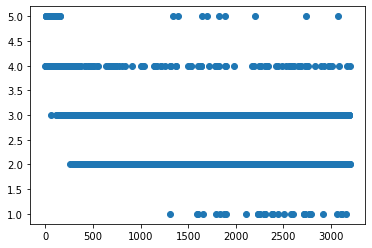

In [7]:
# Now Plot the evolution of gradients during training
# first_grad = np.asarray(first_weights_grad_log)
# last_grad = np.asarray(last_weights_grad_log)

# plot_3d(first_grad, txt="First Linear Layer Gradient")
# plot_3d(last_grad, txt="Last Linear Layer Gradient")

plt.scatter(np.arange(len(rank_log_1)), rank_log_1)

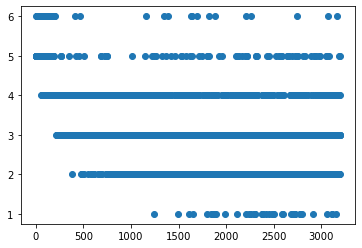

In [8]:
plt.scatter(np.arange(len(rank_log_2)), rank_log_2)

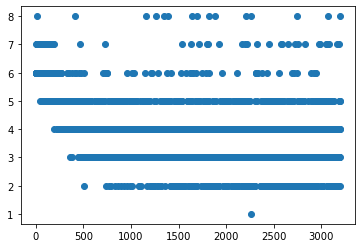

In [9]:
plt.scatter(np.arange(len(rank_log_3)), rank_log_3)

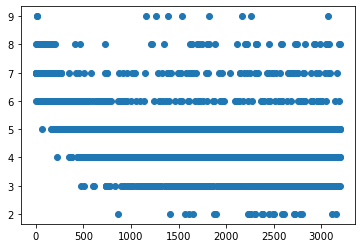

In [11]:
plt.scatter(np.arange(len(rank_log_4)), rank_log_4)